# Clap Prediction of Medium.com
#### Term Project of Advanced Data Analytics for Management Support

In this project, we will try to predict the claps of Medium.com entries by using content of entries and other suitable variables. 
We will structure different Neural Networks(NN). I devide this project into two parts. In the first phase, we will structure Natural Language Process(NLP) models by using corpuses,specifically text and headers. In the second part, we will create NN by using other(mostly numeric, categoric) variables. After all, we will combine outputs of the previous NNs to structure final NN that will give us final predictions.

#### Roadmap
 - Introduction: General examining of the test and train set
 - First Step:   Structuring NLP models
 - Second Step:  Structuring models for other variables
 - Final Step:   Final Model

### Introduction
In this step, we will check main characteristics of train and test data. This part will let us to understand why we should combine NLP and Numeric Variables. 
First we should import necessary packages.

In [1]:
#Let's begin with library imports

#Library used to import libraries
import importlib

#Library used for linear algebra
import numpy as np

#Library used for data structuring 
import pandas as pd

#Library used for graphical representations 
import matplotlib.pyplot as plt

#Library used for working directory 
import os

In [3]:
#Let's set our working directory.
#os.chdir('C:\\Users\\Mahmut\\Desktop\\ADAMS')

We will import our test and train sets from working directory with Data Frame format as follow:

In [187]:
test_set = pd.read_csv('Test.csv')
train_set = pd.read_csv('Train.csv')

##### Important!!!
Before begin to analyze data, I would like to point an important approach that we will use in this task. We will use variables and text sets that are available or can be producable with existing variables both in test and train sets. At the end of the day, accuracy of our test set clap predictions are what we would like to improve and any variable that doesn't exist in test set will not help to increase accuracy.

In [5]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          514 non-null    int64 
 1   index               514 non-null    int64 
 2   Author              514 non-null    object
 3   PublicationDetails  514 non-null    object
 4   Responses           432 non-null    object
 5   Header              506 non-null    object
 6   Text                514 non-null    object
 7   Length              514 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 32.2+ KB


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279577 entries, 0 to 279576
Data columns (total 50 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   audioVersionDurationSec      279577 non-null  int64  
 1   codeBlock                    25179 non-null   object 
 2   codeBlockCount               279577 non-null  float64
 3   collectionId                 137878 non-null  object 
 4   createdDate                  279577 non-null  object 
 5   createdDatetime              279577 non-null  object 
 6   firstPublishedDate           279577 non-null  object 
 7   firstPublishedDatetime       279577 non-null  object 
 8   imageCount                   279577 non-null  int64  
 9   isSubscriptionLocked         279577 non-null  bool   
 10  language                     279577 non-null  object 
 11  latestPublishedDate          279577 non-null  object 
 12  latestPublishedDatetime      279577 non-null  object 
 13 

In [7]:
test_set.head()

,Unnamed: 0,index,Author,PublicationDetails,Responses,Header,Text,Length
0,0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",627 responses,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401
1,1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",156 responses,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972
2,2,2,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 21, 2017",176 responses,The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402
3,3,5,Haseeb Qureshi,"Haseeb Qureshi in HackerNoon.comFeb 19, 2018",72 responses,Stablecoins: designing a price-stable cryptocu...,A useful currency should be a medium of exchan...,19730
4,4,7,William Belk,"William Belk in HackerNoon.comJan 28, 2018",19 responses,Chaos vs. Order — The Cryptocurrency Dilemma,Crypto crypto crypto crypto. It’s here. It’s h...,5324


As shown above, we have a corpus called text. So we will structure our NLP models with respect to these column.

### First Step: Structuring NLP Models
In this step, we will structure an NLP model to predict clap counts.

As always, we will begin with necessary library imports:

In [8]:
# Library re provides regular expressions functionality
import re

# To keep an eye on runtimes
import time

# Saving and loading objects
import pickle

# Library to remove html content
from bs4 import BeautifulSoup

# Standard NLP workflow
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In this step, we will clean, tokenize and lemmatize the content of train_set entries. In the first code block below, in this cleaning process we are following the approach as made in Tutorial 11. In the cleaning process, we add a function to remove URL contents to delete url contents in addition to html contents which are cleaned with beautifulsoup package.

In the first part of the transactions, we will duplicate the text values for two reasons:
<br> -First, having duplicates can misguide further embedding transactions. Duplicates will muniplate the relations of vectors since the relations among words will appear in each duplicated text row,
<br> -Second, decreasing total transaction time with less content in during embedding.

In [9]:
#Choosing text column as a list and dropping duplicates
text=train_set['text'].copy()
text=text.drop_duplicates()

In [10]:
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
def remove_URL(sample):
    return re.sub(r"http\S+", "", sample)

In [12]:
def clean_texts(df):

    contents = []

    lemmatizer = WordNetLemmatizer()

    print('*' * 40)
    print('Cleaning {} texts.'.format(df.shape[0]))
    counter = 0
    for content in df:
        
        # remove URL/http content
        content=remove_URL(content)
        
        # remove html content
        content_text = BeautifulSoup(content).get_text()
        
        # remove non-alphabetic characters
        content_text = re.sub("[^a-zA-Z]"," ", content_text)
    
        # tokenize the sentences
        words = word_tokenize(content_text.lower())
  
        # filter stopwords
        words = [w for w in words if w not in stopwords.words("english")]
        
        # lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    
        contents.append(lemma_words)
              
        if (counter > 0 and counter % 500 == 0):
            print('Processed {} reviews'.format(counter))
            
        counter += 1
        
    print('DONE')
    print('*' * 40)

    return(contents) 

In this step, we will apply the cleaning tokenization and lemmatization transactions that we defined above. We saved our cleaned text and integrated a code block for potential re-runs in which we can load previously cleaned text.

In [ ]:
#Applying the cleaning,tokenization and lemmatization 
cleaned_text=clean_texts(text)

In [14]:
#For saving the cleaned text
#with open('cleaned_text.pkl','wb') as path_name:
#   pickle.dump(cleaned_text, path_name)

In [25]:
#For loading previously saved cleaned_text data 
#with open('cleaned_text.pkl','rb') as path_name:
#    cleaned_text = pickle.load(path_name)

We cleaned and tokenized contents and stored them as list. We will convert tokenized values to a new data frame called __text__. In addition to tokenized values, we will add original text values into __text__ data frame to use as key value while merging with other train set contents.

In [8]:
#Converting text list to dataframe object
text=pd.DataFrame(text)

In [9]:
#After drop duplicates we will assign new index
text['new_index']=range(len(text))
text=text.set_index(text['new_index'],drop=True)

In [10]:
text=text.drop(columns='new_index')

In [11]:
#Merging cleaned text lists with text data frame
text['cleaned_text']=''
for i in range(len(text)):
    text['cleaned_text'][i]=cleaned_text[i]

In the above part, we structured a dataframe, called __text__ with non-cleaned text data and clean version of it. In the below part, we will structure another dataframe that include other variables that we need during nlp process of text values.This new dataframe called __train_set_nlp__. We will combine both these dataframe with left join function by using text values in both dataframes as key Ids.

In [12]:
#Structuring train_set_nlp with necessary variables for further NLP transactions
train_set_nlp=train_set[['postId','totalClapCount','text','language']].copy()

In [13]:
#Dropping duplicates
train_set_nlp=train_set_nlp.drop_duplicates()

In [14]:
#Setting new indexes after drop duplicates
train_set_nlp['new_index']=range(len(train_set_nlp))
train_set_nlp=train_set_nlp.set_index(train_set_nlp['new_index'],drop=True)

In [15]:
train_set_nlp

,postId,totalClapCount,text,language,new_index
new_index,,,,,
0,10007d3018fe,100,"Private Business, Government and Blockchain\n\...",en,0
1,1000c43bcb97,0,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,en,1
2,100139913e4c,0,"Ascent of data Science, SAS and Big data Analy...",en,2
3,1002a55eca89,50,Can a robot love us better than another human ...,en,3
4,10033db0a000,27,"2017 Big Data, AI and IOT Use Cases\nAn Active...",en,4
...,...,...,...,...,...
72332,ffde401fb3ae,4,Analyzing extreme skiing and snowboarding in R...,en,72332
72333,ffe0bc7972b4,21,Desarrollo de una aplicación de ChatBot con Re...,es,72333
72334,ffe3f43436b8,567,How to Build a Smart Chatbot Assistant with Ch...,en,72334


In [16]:
#Making left join to combine our data frames 
train_set_nlp_raw=pd.merge(train_set_nlp,text,on='text',how='left')

In [372]:
len(train_set_nlp_raw[train_set_nlp_raw['language']=='en'])/len(train_set_nlp_raw)

0.9176493357479575

In that part, we will make last modifications before embeddings. First of all, as shown below we checked languages of contents. Found that just c.8% of values are not in english. We will make our embeddings in gensim that doesn't support all languages. For prevention of any potential confusing issue, we will drop all non-english contents. 

In [17]:
train_set_nlp_raw.language.value_counts()

en         66380
es           890
zh-Hant      880
pt           873
fr           551
tr           378
th           350
ru           347
ja           334
it           218
id           200
ko           200
zh           105
de           102
un            93
vi            88
nl            71
sv            57
pl            25
cs            22
bn            20
no            15
is            15
da            13
my            12
uk            10
ar            10
mn             9
el             8
lo             7
hi             6
si             5
la             5
sk             4
bg             4
sr             3
ro             3
fa             3
ka             3
lv             2
ms             2
ca             2
hu             2
nn             2
mk             1
sl             1
az             1
mr             1
ml             1
lt             1
te             1
fi             1
Name: language, dtype: int64

In [18]:
#Dropping non-english contents
train_set_nlp=train_set_nlp_raw[train_set_nlp_raw['language']=='en'].copy()

In [19]:
#Here we have just contents in english
train_set_nlp.language.value_counts()

en    66380
Name: language, dtype: int64

In [78]:
#In addition to cleaned,tokenized list of list set ,called cleaned_text, we extract new list of list that includes just english values
cleaned_text_en=train_set_nlp['cleaned_text'].tolist()

Up until now, we have focused unigrams, so we kept all words as single values. However, we know that some values have different meanings when they come together. In our case, machine learning is a very obvious example. In spite machine and learning are totally seperate, their combination has a different meaning than both of them. So it is good idea to check bigrams in our corpuses. 

We trained bigram model with min count 5. In case any combination appears more than five times than the model take it into consideration as a bigram.

In [79]:
from gensim.models.phrases import Phrases

bigram_text_en = Phrases(cleaned_text_en,min_count=5) 

Let's check, are they really important for our contents or not:

In [81]:
import collections

bigram_counter = collections.Counter()
for key in bigram_text_en.vocab.keys():
    if key.decode().find('_')>-1: 
        bigram_counter[key] += bigram_text_en.vocab[key]

In [82]:
bigram_counter.most_common(25)

[(b'machine_learn', 104880),
 (b'artificial_intelligence', 64671),
 (b'neural_network', 40246),
 (b'deep_learn', 38678),
 (b'data_science', 37884),
 (b'data_scientist', 21326),
 (b'big_data', 15502),
 (b'data_set', 14161),
 (b'natural_language', 11854),
 (b'real_time', 11221),
 (b'e_g', 10790),
 (b'learn_algorithm', 10541),
 (b'social_medium', 9953),
 (b'look_like', 9681),
 (b'learn_model', 9462),
 (b'use_case', 8752),
 (b'make_sure', 8700),
 (b'training_data', 8621),
 (b'decision_make', 8368),
 (b'open_source', 8309),
 (b'real_world', 7754),
 (b'reinforcement_learn', 7344),
 (b'use_ai', 7287),
 (b'language_processing', 7282),
 (b'computer_vision', 7272)]

If you check these bigrams, it is easy to realize that all these combinations have their own meanings.Furthermore, numbers in the tuples show that authors use these terms frequently so they have significant impacts in the corpuses. Because of all these reasons, we decided to chance suitable unigrams with bigrams in our cleaned text data.

In [83]:
cleaned_bigram_text_en=[]
for i in range(len(cleaned_text_en)):
    cleaned_bigram_text_en.append(bigram_text_en[cleaned_text_en[i]])

So we completed all previous transactions to train our embeddings. 

 - We will make embedding with embedding dimension of 200. We know the industry standarts between 100 to 300. We decided the middle point to make this transaction faster but not weak.
 - As in our bigram transaction, our minimum count parameter is five. So we will consider the words that appear at least five times in our cleaned text.
 - We would like to make these transaction as fast as possible so we will run a multiprocessing code to find out how many cores our computer have and will use all of them to make paralel transactions simultaneously.


In [84]:
import multiprocessing

cores=multiprocessing.cpu_count()

In [42]:
from gensim.models import Word2Vec

emb_dim=200
model_bigram = Word2Vec(cleaned_bigram_text_en, 
                         min_count=5,  
                         window=5,     
                         iter=100,     
                         size=emb_dim, 
                         workers=cores) 

In [88]:
words=list(model_bigram.wv.vocab)

Now we made embeddings and saved with word2vec format. We named it as model_index and we will use it in pre-trained embeddings model.

In [85]:
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [87]:
embs="en_bigram_embeddings.model"
save_as_bin = False
#model_bigram.wv.save_word2vec_format(embs, binary=save_as_bin)

In [88]:
model_index = KeyedVectors.load_word2vec_format(embs, binary=save_as_bin)

We structured our content data for NLP means that we did all transactions for x variable. So it is time to focus y variable which is totalClapCount. Lets make an histogram to check its distribution 

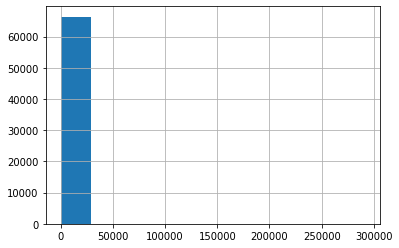

In [358]:
train_set_nlp['totalClapCount'].hist(bins=10)

As observed above, distribution of the clap counts is very far from an ideal normal distribution. For this kind of problems, one of the ways is implementing logarithmic transformation. While implementing logarithmic transformation we will add one to all clap counts since we have values as 0. 

In [89]:
#Log-transformed clap counts stored in a new columns called transform
train_set_nlp['transform']=np.log(train_set_nlp['totalClapCount']+1)

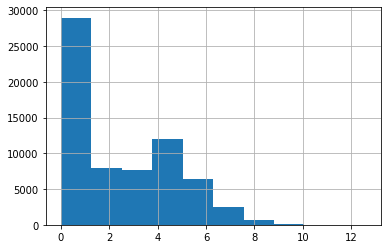

In [361]:
train_set_nlp['transform'].hist(bins=10)

We tokenized contexts to train them. Now it is done so we will detokenize cleaned text and will use it for our sentiment analysis.

In [90]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

train_set_nlp['cleaned_bi_text'] = [TreebankWordDetokenizer().detokenize(text) for text in cleaned_bigram_text_en]

In [91]:
train_set_nlp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66380 entries, 0 to 66379
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   postId           66380 non-null  object 
 1   totalClapCount   66380 non-null  int64  
 2   text             66380 non-null  object 
 3   language         66380 non-null  object 
 4   cleaned_text     66380 non-null  object 
 5   transform        66380 non-null  float64
 6   cleaned_bi_text  66380 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 4.1+ MB


All transactions are done for nlp modelling. We will get x and y variables into a new dataframe to decrease memory usage. As shown above it is aroun 7.3 now.

In [92]:
train_nlp_model=train_set_nlp[['cleaned_bi_text','transform']].copy()

In [93]:
train_nlp_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66380 entries, 0 to 66379
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cleaned_bi_text  66380 non-null  object 
 1   transform        66380 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


We kept just final necessary input and output that led to decrease memory usage to 1.5 MB.

For replicability we will keep seed always same which is as follow:

In [117]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

We will not split our data into train and test because during the application of models we already using validation sets to test our trainings. In addition to that our test set is already something splitted that we will apply at the end of all tasks. Furthermore, we would like to keep train set as big as possible to make more accurate training.

In [116]:
X_train=train_nlp_model['cleaned_bi_text'] 
Y_train=train_nlp_model['transform']

In [120]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_WORDS = 10000   

tokenizer_obj = Tokenizer(NUM_WORDS, oov_token=1)  
tokenizer_obj.fit_on_texts(X_train)  

In [121]:
X_tr_int = tokenizer_obj.texts_to_sequences(X_train)

For deciding max review of length, we checked the length of tokenized contents list. We can see from percentiles that this value is explonantial. So we gave a proper length to exceeds most of the contents length but not big to save computer performance. 

In [103]:
train_set_nlp['Length_list'] = train_set_nlp.cleaned_text.apply(lambda x: len(x))
train_set_nlp['Length_list'].describe()

count    66380.000000
mean       505.940343
std        462.500418
min          0.000000
25%        235.000000
50%        400.000000
75%        635.000000
max      12918.000000
Name: Length_list, dtype: float64

In [122]:
MAX_REVIEW_LENGTH = 1000

X_tr_int_pad = pad_sequences(X_tr_int, MAX_REVIEW_LENGTH)

In [123]:
from keras.models import Sequential
from keras.layers import Dense, Embedding,GRU, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

In [108]:
NB_HIDDEN = 16
EPOCH = 3
BATCH_SIZE = 64 
EMBEDDING_DIM = 200
VAL_SPLIT = 0.25  

We get embedding weights by using following transactions:

In [109]:
def get_embedding_matrix(tokenizer, pretrain, vocab_size):
  
    dim = 0
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size        
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))
    
    
    
    emb_mat = np.zeros((vocab_size, dim))

    
    oov_words = []

    for word, i in tokenizer.word_index.items():  
       
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
    print('Created embedding matrix of shape {}'.format(emb_mat.shape))
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return (emb_mat, oov_words)

In [124]:
embs_weights, _ = get_embedding_matrix(tokenizer_obj,model_index, NUM_WORDS)

Created embedding matrix of shape (10000, 200)
Encountered 202387 out-of-vocabulary words.


We will structure some models for NLP. Mainly we have three models. In the first one, we are using pre-trained weights. In the second one, we are not using pre_trained weihts. In last model, we are using pre-trained weights but the difference is it is training itself.

In [111]:
embedding_layer=Embedding(input_dim=NUM_WORDS, 
                          output_dim=EMBEDDING_DIM, 
                          input_length=MAX_REVIEW_LENGTH,
                          embeddings_initializer=Constant(embs_weights), 
                          trainable=False  
                         )

model1=Sequential()                        
model1.add(embedding_layer)
model1.add(GRU(NB_HIDDEN))
model1.add(Dense(1, activation="sigmoid"))
model1.compile(loss="MSE", optimizer="adam", metrics=["accuracy"])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                10416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 2,010,433
Trainable params: 10,433
Non-trainable params: 2,000,000
_________________________________________________________________


In [314]:
model1_story = model1.fit(X_tr_int_pad, Y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)

Train on 49785 samples, validate on 16595 samples
Epoch 1/3
49785/49785 [==============================] - 325s 7ms/step - loss: 5.3981 - accuracy: 0.0030 - val_loss: 11.9979 - val_accuracy: 0.0000e+00
Epoch 2/3
49785/49785 [==============================] - 328s 7ms/step - loss: 5.3644 - accuracy: 0.0020 - val_loss: 11.9935 - val_accuracy: 0.0019
Epoch 3/3
49785/49785 [==============================] - 328s 7ms/step - loss: 5.3612 - accuracy: 0.0052 - val_loss: 11.9922 - val_accuracy: 0.0020


In [127]:
# Embedding layer
embedding_layer=Embedding(input_dim=NUM_WORDS, 
                          output_dim=EMBEDDING_DIM, 
                          input_length=MAX_REVIEW_LENGTH
                         )
# GRU text classifier
model2=Sequential()                        
model2.add(embedding_layer)
model2.add(GRU(NB_HIDDEN))
model2.add(Dense(1, activation="sigmoid"))
model2.compile(loss="MSE", optimizer="adam", metrics=["accuracy"])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 200)         2000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                10416     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 2,010,433
Trainable params: 2,010,433
Non-trainable params: 0
_________________________________________________________________


In [315]:
model2_story = model2.fit(X_tr_int_pad, Y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)

Train on 49785 samples, validate on 16595 samples
Epoch 1/3
49785/49785 [==============================] - 386s 8ms/step - loss: 5.3815 - accuracy: 0.0146 - val_loss: 12.0016 - val_accuracy: 0.0048
Epoch 2/3
49785/49785 [==============================] - 401s 8ms/step - loss: 5.3442 - accuracy: 0.0262 - val_loss: 12.0564 - val_accuracy: 0.0098
Epoch 3/3
49785/49785 [==============================] - 384s 8ms/step - loss: 5.3201 - accuracy: 0.0533 - val_loss: 12.0633 - val_accuracy: 0.0114


In [129]:
GRUw = model1.layers[1].get_weights()

In [330]:
model3=Sequential()
embedding_layer=Embedding(NUM_WORDS, 
                         EMBEDDING_DIM,  
                         embeddings_initializer=Constant(embs_weights), 
                         input_length=MAX_REVIEW_LENGTH, 
                         trainable=True  
                         )
model3.add(embedding_layer)

model3.add(GRU(NB_HIDDEN, weights=GRUw))
model3.add(Dense(1, activation="sigmoid"))
model3.compile(loss="MSE", optimizer="adam", metrics=["accuracy"])
model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 200)         2000000   
_________________________________________________________________
gru_4 (GRU)                  (None, 16)                10416     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 2,010,433
Trainable params: 2,010,433
Non-trainable params: 0
_________________________________________________________________


In [455]:
model3_story = model3.fit(X_tr_int_pad, Y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)

We tried all these three models and according to losses the second one is the best to use as NLP.

### Second Step: Structuring Models from Other Variables
In this step, we will try to extract variables that are both appear in text and train sets. We know that train set is really rich about number of variables. However, there are just couple of variables appear in test set because of this reason we will begin by analyzing our test set to see which variables are available.

In [188]:
test_set.head()

,Unnamed: 0,index,Author,PublicationDetails,Responses,Header,Text,Length
0,0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",627 responses,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401
1,1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",156 responses,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972
2,2,2,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 21, 2017",176 responses,The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402
3,3,5,Haseeb Qureshi,"Haseeb Qureshi in HackerNoon.comFeb 19, 2018",72 responses,Stablecoins: designing a price-stable cryptocu...,A useful currency should be a medium of exchan...,19730
4,4,7,William Belk,"William Belk in HackerNoon.comJan 28, 2018",19 responses,Chaos vs. Order — The Cryptocurrency Dilemma,Crypto crypto crypto crypto. It’s here. It’s h...,5324


We can check the details of variables.

Publication Details is the first one since it covers more than one variable so we can split it into groups. We split Publication Details as follow:
<br>
<br>First we will identify months since it is a good approach to split date part first and remaining part after it.

In [189]:
months=('Jan ','Feb ','Mar ','Apr ','May ','Jun ','Jul ','Aug ','Sep ','Oct ','Nov ','Dec ')

In [190]:
date = {}
publisher={}
for month in months:
    for i in range(len(test_set['PublicationDetails'])):
        if month in test_set['PublicationDetails'][i]:
            text=test_set['PublicationDetails'][i]
            test_index=test_set['index'][i]
            posit=text.find(month)
            date[test_index]=text[posit:]
            publisher[test_index]=text[:posit]

In [191]:
import collections
date = collections.OrderedDict(sorted(date.items()))
publisher = collections.OrderedDict(sorted(publisher.items()))

We extracted Publish Date as PublishDate and remainings as Publisher. However, remaining part consist of more than one variable. These variables are author name and website both can be splitted with 'in'. We will do these transactions and integrate them to dataframe in next two code blocks.

In [192]:
test_set['PublishDate']=pd.DataFrame(list(date.values()))
test_set['Publisher']=pd.DataFrame(list(publisher.values()))

In [193]:
devided=test_set['Publisher'].str.split(' in ',n=1,expand=True)
test_set['Extracted Author']=devided[0]
test_set['WebSite']=devided[1]

In [194]:
test_set[:]

,Unnamed: 0,index,Author,PublicationDetails,Responses,Header,Text,Length,PublishDate,Publisher,Extracted Author,WebSite
0,0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",627 responses,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401,"Jul 31, 2017",Daniel Jeffries in HackerNoon.com,Daniel Jeffries,HackerNoon.com
1,1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",156 responses,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972,"Dec 6, 2017",Noam Levenson in HackerNoon.com,Noam Levenson,HackerNoon.com
2,2,2,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 21, 2017",176 responses,The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402,"Jul 21, 2017",Daniel Jeffries in HackerNoon.com,Daniel Jeffries,HackerNoon.com
3,3,5,Haseeb Qureshi,"Haseeb Qureshi in HackerNoon.comFeb 19, 2018",72 responses,Stablecoins: designing a price-stable cryptocu...,A useful currency should be a medium of exchan...,19730,"Feb 19, 2018",Haseeb Qureshi in HackerNoon.com,Haseeb Qureshi,HackerNoon.com
4,4,7,William Belk,"William Belk in HackerNoon.comJan 28, 2018",19 responses,Chaos vs. Order — The Cryptocurrency Dilemma,Crypto crypto crypto crypto. It’s here. It’s h...,5324,"Jan 28, 2018",William Belk in HackerNoon.com,William Belk,HackerNoon.com
...,...,...,...,...,...,...,...,...,...,...,...,...
509,509,598,"Jun 9, 2016","Tim Romero in Startup Lessons LearnedJun 9, 2016",181 responses,"Why I turned down $500K, Pissed off my investo...",I just did what no startup founder is ever sup...,9025,"Jun 9, 2016",Tim Romero in Startup Lessons Learned,Tim Romero,Startup Lessons Learned
510,510,599,"Jun 10, 2016","Product HuntJun 10, 2016",24 responses,These Tools Will Help You Launch Your Startup,If you’re embarking on the startup journey and...,5571,"Jun 10, 2016",Product Hunt,Product Hunt,None
511,511,600,Mar-19,Joe ProcopioMar 19,24 responses,Why Startups Fall Apart at 50 Employees,Fuck you startups with your extravagant partie...,475,Mar 19,Joe Procopio,Joe Procopio,None
512,512,601,"Mar 18, 2016","Winerist in Be YourselfMar 18, 2016",116 responses,Beware of Startup Prostitution,Note: This is not a post to glorify prostituti...,13483,"Mar 18, 2016",Winerist in Be Yourself,Winerist,Be Yourself


As shown above, we have two variables Author and Extracted Author. Author variable is not very well structured column. You can easily obsorve at last lines above. On the other hand, our extracted author variable is more proper to use. This is why we will switch Author and Extracted Author then we will drop Extracted Author, PublicationDetails and Publisher variables since they are used during the process and not necessary anymore.

In [195]:
test_set['Author']=test_set['Extracted Author']
test_set=test_set.drop(columns=['PublicationDetails','Extracted Author','Publisher'])

From this group of data, we can use Author as an input but first we have to check we have all these Authors in data set. At the end of the day, if we would like to use Authors as categoric variables or embedded variables. In any case their values have to be trained in train set and all they are not appear in train set.

We have an important variable that we can use to see total number of days since publication day of the content.
We don't know the scrapping time of the test set so we can assumed that both train and test sets scrapping times are same. We know exact scrapping time of the training set and we checked that it is not later then the latest publish date in test set. So we can use scrapping time of train set for test set.

In [196]:
max(test_set.PublishDate)

'Sep 7, 2018'

In [197]:
test_set2=test_set.copy()

In [198]:
from datetime import datetime

In [199]:
for i in range(len(test_set['PublishDate'])):
    x=test_set['PublishDate'][i]
    if len(x)<7:
        test_set['PublishDate'][i]=x+', 2017'

C:\Users\Mahmut\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [200]:
for i in range(len(test_set['PublishDate'])):
    test_set['PublishDate'][i]=datetime.strptime(test_set['PublishDate'][i],"%b %d, %Y" )

C:\Users\Mahmut\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [212]:
test_set['scrappedDate']=pd.to_datetime(test_set['scrappedDate']).apply(lambda x: x.date())

In [214]:
test_set['PublishDate']=pd.to_datetime(test_set['PublishDate']).apply(lambda x: x.date())

In [219]:
test_set['PublishedDay']=test_set['scrappedDate']-test_set['PublishDate']

In [220]:
test_set2=test_set.copy()

In [221]:
test_set2['PublishedDay'] = test_set2['PublishedDay'].dt.days.astype('int16')

In [222]:
test_set2

,Unnamed: 0,index,Author,Responses,Header,Text,Length,PublishDate,WebSite,scrappedDate,PublishedDay
0,0,0,Daniel Jeffries,627 responses,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401,2017-07-31,HackerNoon.com,2018-11-04,461
1,1,1,Noam Levenson,156 responses,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972,2017-12-06,HackerNoon.com,2018-11-04,333
2,2,2,Daniel Jeffries,176 responses,The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402,2017-07-21,HackerNoon.com,2018-11-04,471
3,3,5,Haseeb Qureshi,72 responses,Stablecoins: designing a price-stable cryptocu...,A useful currency should be a medium of exchan...,19730,2018-02-19,HackerNoon.com,2018-11-04,258
4,4,7,William Belk,19 responses,Chaos vs. Order — The Cryptocurrency Dilemma,Crypto crypto crypto crypto. It’s here. It’s h...,5324,2018-01-28,HackerNoon.com,2018-11-04,280
...,...,...,...,...,...,...,...,...,...,...,...
509,509,598,Tim Romero,181 responses,"Why I turned down $500K, Pissed off my investo...",I just did what no startup founder is ever sup...,9025,2016-06-09,Startup Lessons Learned,2018-11-04,878
510,510,599,Product Hunt,24 responses,These Tools Will Help You Launch Your Startup,If you’re embarking on the startup journey and...,5571,2016-06-10,None,2018-11-04,877
511,511,600,Joe Procopio,24 responses,Why Startups Fall Apart at 50 Employees,Fuck you startups with your extravagant partie...,475,2017-03-19,None,2018-11-04,595
512,512,601,Winerist,116 responses,Beware of Startup Prostitution,Note: This is not a post to glorify prostituti...,13483,2016-03-18,Be Yourself,2018-11-04,961


We can use also Length and Responses variables from test set. Responses already appear in train set as responsesCreatedCount. In addition to that we can use Length by calculating length of text values in train set.

In [374]:
test_set2.Responses=test_set2.Responses.str.split('\s+').str[0]

We checked null values in the variables that we will use in NNs. We have to get rid of null values.

In [456]:
test_set2.Length.isnull().sum()

0

In [226]:
test_set2.PublishedDay.isnull().sum()

0

In [381]:
test_set2.Responses.isnull().sum()

0

In [379]:
test_set2['Responses'] = pd.to_numeric(test_set2['Responses'], errors='coerce')
test_set2['Responses'] = test_set2['Responses'].astype(np.float16)
test_set2['Responses'].isna().sum()

85

In [380]:
for col in test_set2.select_dtypes(include='float16').columns:
    if test_set2[col].isna().sum() > 0:
        m = test_set2[col].median()
        test_set2[col].fillna(m, inplace=True)

We got rid of null values in Responses column and changed them with mean value.

In [382]:
test_set2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    514 non-null    int64  
 1   index         514 non-null    int64  
 2   Author        514 non-null    object 
 3   Responses     514 non-null    float16
 4   Header        506 non-null    object 
 5   Text          514 non-null    object 
 6   Length        514 non-null    int64  
 7   PublishDate   514 non-null    object 
 8   WebSite       420 non-null    object 
 9   scrappedDate  514 non-null    object 
 10  PublishedDay  514 non-null    int16  
dtypes: float16(1), int16(1), int64(3), object(6)
memory usage: 38.3+ KB


In [383]:
test_set_final=test_set2[['index','Text','Length','PublishedDay','Responses']].copy()

In [384]:
test_set_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         514 non-null    int64  
 1   Text          514 non-null    object 
 2   Length        514 non-null    int64  
 3   PublishedDay  514 non-null    int16  
 4   Responses     514 non-null    float16
dtypes: float16(1), int16(1), int64(2), object(1)
memory usage: 14.2+ KB


After completion of numeric variables, we can also complete all transactions on test set including tokenizetion and cleaning of text.

In [333]:
test_text=test_set['Text']

In [334]:
cleaned_test_text=clean_texts(test_text)

****************************************
Cleaning 514 texts.
Processed 500 reviews
DONE
****************************************


In [335]:
bigram_test_text = Phrases(cleaned_test_text,min_count=5)

In [336]:
cleaned_bigram_test_text=[]
for i in range(len(cleaned_test_text)):
    cleaned_bigram_test_text.append(bigram_text_en[cleaned_test_text[i]])

In [385]:
test_set_final['cleaned_text_de']=cleaned_bigram_test_text

In [386]:
test_set_final['cleaned_text'] = [TreebankWordDetokenizer().detokenize(text) for text in cleaned_bigram_test_text]

In [387]:
test_set_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            514 non-null    int64  
 1   Text             514 non-null    object 
 2   Length           514 non-null    int64  
 3   PublishedDay     514 non-null    int16  
 4   Responses        514 non-null    float16
 5   cleaned_text_de  514 non-null    object 
 6   cleaned_text     514 non-null    object 
dtypes: float16(1), int16(1), int64(2), object(3)
memory usage: 22.2+ KB


As discussed above, variables that we can use in addition to text data are responses, published day and length of the text. Now we will extract these data in train set to use them in a new NN.

In [242]:
#calculating PublishedDay in train set
train_set['scrappedDate'] = pd.to_datetime(train_set['scrappedDate'], format='%Y%m%d')
train_set['firstPublishedDate'] = pd.to_datetime(train_set['firstPublishedDate'], format='%Y-%m-%d')

In [243]:
train_set['PublishedDay']=train_set['scrappedDate']-train_set['firstPublishedDate']

In [244]:
train_set['PublishedDay'] = train_set['PublishedDay'].dt.days.astype('int16')

In [245]:
#calculating Length in train set
train_set['Length']=train_set['text'].str.len()

In [246]:
train_set_NN=train_set[['postId','responsesCreatedCount','PublishedDay','Length','language','totalClapCount']].copy()

In [247]:
train_set_NN=train_set_NN.drop_duplicates()

In [248]:
train_set_NN=train_set_NN[train_set_NN['language']=='en'].copy()

In [249]:
train_set_NN=train_set_NN.drop(columns='language')

In [250]:
train_set_NN['new_index']=range(len(train_set_NN))
train_set_NN=train_set_NN.set_index(train_set_NN['new_index'],drop=True)
train_set_NN=train_set_NN.drop(columns='new_index')

So we have all variables below to use them to structure a neural network:

In [251]:
train_set_NN.head()

,postId,responsesCreatedCount,PublishedDay,Length,totalClapCount
new_index,,,,,
0,10007d3018fe,0,47,1244,100
1,1000c43bcb97,0,301,30073,0
2,100139913e4c,0,241,3453,0
3,1002a55eca89,0,202,1020,50
4,10033db0a000,0,378,10981,27
...,...,...,...,...,...
66375,ffde381af7d1,1,284,6053,92
66376,ffde401fb3ae,1,180,5713,4
66377,ffe3f43436b8,0,145,9523,567


In [252]:
#Identified x and y variables to use
x=train_set_NN[['responsesCreatedCount','PublishedDay','Length']]
y=train_set_NN[['totalClapCount']]

In [253]:
#Imported necessary libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [256]:
#We will scale all our numeric variables
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))
xscale=scaler_x.transform(x)
print(scaler_y.fit(y))
yscale=scaler_y.transform(y)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [261]:
#We identified variables to train NN
X_train=xscale
y_train=yscale

Here is the model that we structured before optimizing parameters.

In [ ]:
model_var = Sequential()
model_var.add(Dense(12, input_dim=3, kernel_initializer='normal', activation='relu'))
model_var.add(Dense(8, activation='relu'))
model_var.add(Dense(1, activation='linear'))
model_var.summary()

In [ ]:
model_var.compile(loss='mse', optimizer='adam', metrics=['mse','accuracy'])

In [ ]:
history = model_var.fit(X_train, y_train, epochs=50, batch_size=16,  verbose=1, validation_split=0.25)

In that part, we will optimize parameters as we learned in the tutorial. In the first phase, we optimizing batch size and epochs. We find out the best epoch and batch size parameters as 30 and 32.

In [271]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from sklearn.model_selection import GridSearchCV

In [274]:
def network():
    model_var = Sequential()
    model_var.add(Dense(12, input_dim=3, kernel_initializer='normal', activation='relu'))
    model_var.add(Dense(8, activation='relu'))
    model_var.add(Dense(1, activation='linear'))
  
    model_var.compile(loss='mse', optimizer='adam', metrics=['mse','accuracy'])
    
    return model_var

model_var = KerasClassifier(build_fn=network, verbose=0)

In [275]:
batchsize = [32, 64, 128, 256, 512]
epochs = [10,30,60]

param_grid = dict(batch_size=batchsize, epochs=epochs)
param_grid 

{'batch_size': [32, 64, 128, 256, 512], 'epochs': [10, 30, 60]}

In [276]:
grid = GridSearchCV(estimator=model_var, param_grid=param_grid, n_jobs=-1,cv=3)
results = grid.fit(X_train, y_train) 
print("Best: %f using %s" % (results.best_score_, results.best_params_))

C:\Users\Mahmut\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.007653 using {'batch_size': 32, 'epochs': 30}


In the second part of optimization, we looked for an ideal optimizer. You can see below that the Adamax is the ideal optimizer for our NN

In [277]:
def optim (optimizer='SGD'):
    model_var = Sequential()
    model_var.add(Dense(12, input_dim=3, kernel_initializer='normal', activation='relu'))
    model_var.add(Dense(8, activation='relu'))
    model_var.add(Dense(1, activation='linear'))

    model_var.compile(loss='mse', optimizer='adam', metrics=['mse','accuracy'])
    
    return model_var

model_var = KerasClassifier(build_fn=optim, epochs=32, batch_size=30, verbose=0)
# define the grid search parameters
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizers) 
grid = GridSearchCV(estimator=model_var, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.002275 using {'optimizer': 'Adamax'}


Now we will implement results into model to idealize it.

In [278]:
model_var = Sequential()
model_var.add(Dense(12, input_dim=3, kernel_initializer='normal', activation='relu'))
model_var.add(Dense(8, activation='relu'))
model_var.add(Dense(1, activation='linear'))
model_var.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 12)                48        
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [279]:
model_var.compile(loss='mse', optimizer='Adamax', metrics=['mse','accuracy'])

In [280]:
history = model_var.fit(X_train, y_train, epochs=30, batch_size=32,  verbose=1, validation_split=0.25)

Train on 49785 samples, validate on 16595 samples
Epoch 1/30
49785/49785 [==============================] - 2s 40us/step - loss: 4.2187e-05 - mse: 4.2187e-05 - accuracy: 0.3675 - val_loss: 3.7783e-05 - val_mse: 3.7783e-05 - val_accuracy: 0.1544
Epoch 2/30
49785/49785 [==============================] - 2s 35us/step - loss: 4.1542e-05 - mse: 4.1542e-05 - accuracy: 0.3675 - val_loss: 3.7002e-05 - val_mse: 3.7002e-05 - val_accuracy: 0.1544
Epoch 3/30
49785/49785 [==============================] - 2s 35us/step - loss: 4.1091e-05 - mse: 4.1091e-05 - accuracy: 0.3675 - val_loss: 3.6316e-05 - val_mse: 3.6316e-05 - val_accuracy: 0.1544
Epoch 4/30
49785/49785 [==============================] - 2s 40us/step - loss: 4.0504e-05 - mse: 4.0504e-05 - accuracy: 0.3675 - val_loss: 3.5736e-05 - val_mse: 3.5736e-05 - val_accuracy: 0.1544
Epoch 5/30
49785/49785 [==============================] - 2s 43us/step - loss: 3.9952e-05 - mse: 3.9952e-05 - accuracy: 0.3675 - val_loss: 3.4465e-05 - val_mse: 3.4465e-0

dict_keys(['val_loss', 'val_mse', 'val_accuracy', 'loss', 'mse', 'accuracy'])


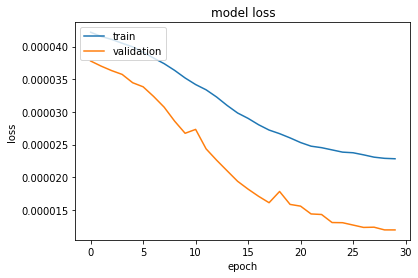

In [281]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Final Step: Structuring Final Model
In this step, we will put all train set variables into ideal NLP and NN models that we pick above and we will predict some clap counts. As a last step, we will combine these variables and will make our last value predictions.

In [282]:
#using all train set rows to extract our Variable based Neural Network Predictions
y_val_NN=model_var.predict(xscale)

In [283]:
y_val_NN

array([[-1.1308491e-04],
       [ 7.1950257e-04],
       [ 7.2628260e-05],
       ...,
       [ 1.4351308e-04],
       [ 1.0275841e-04],
       [ 9.3862414e-05]], dtype=float32)

In [285]:
#making inverse transformation to get exact values
Y_hat_NN=scaler_y.inverse_transform(y_val_NN)

In [286]:
Y_hat_NN

array([[-32.98755 ],
       [209.88321 ],
       [ 21.1861  ],
       ...,
       [ 41.86363 ],
       [ 29.975245],
       [ 27.38023 ]], dtype=float32)

In [326]:
#adding predictions to data frame
train_set_NN['y_hat_NN']=pd.DataFrame(Y_hat_NN)

In [322]:
#using all training set rows to extract our ideal NLP model prediction results
y_val_NLP=model2.predict(X_tr_int_pad)

In [318]:
#adding predictions to data frame
train_set_NN['y_val_NLP']=pd.DataFrame(y_val_NLP)

In [319]:
#making inverse log transformation
train_set_NN['y_hat_NLP']=(np.exp(train_set_NN['y_val_NLP']))-1

In [327]:
train_set_NN=train_set_NN.drop(columns='y_val_NLP')

In [328]:
train_set_NN

,postId,responsesCreatedCount,PublishedDay,Length,totalClapCount,y_hat_NLP,y_hat_NN
new_index,,,,,,,
0,10007d3018fe,0,47,1244,100,1.716988,-32.987549
1,1000c43bcb97,0,301,30073,0,1.718036,209.883209
2,100139913e4c,0,241,3453,0,1.709819,21.186100
3,1002a55eca89,0,202,1020,50,1.716948,-2.888421
4,10033db0a000,0,378,10981,27,1.717958,99.010460
...,...,...,...,...,...,...,...
66375,ffde381af7d1,1,284,6053,92,1.718151,195.117279
66376,ffde401fb3ae,1,180,5713,4,1.718076,171.677383
66377,ffe3f43436b8,0,145,9523,567,1.717938,41.863628


Here is the final model. We will put our prediction results from both model into a new neural network to predict final clap predictions.

In [342]:
final_x=train_set_NN[['y_hat_NLP','y_hat_NN']]
final_y=train_set_NN[['totalClapCount']]

In [413]:
model_last = Sequential()
model_last.add(Dense(12, input_dim=2, kernel_initializer='normal', activation='relu'))
model_last.add(Dense(8, activation='relu'))
model_last.add(Dense(1, activation='linear'))
model_last.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 12)                36        
_________________________________________________________________
dense_51 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 9         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [414]:
model_last.compile(loss='mse', optimizer='Adamax', metrics=['mse','accuracy'])

In [471]:
history = model_last.fit(final_x, final_y, epochs=30, batch_size=502,  verbose=1, validation_split=0.25)

Train on 49785 samples, validate on 16595 samples
Epoch 1/30
49785/49785 [==============================] - 0s 5us/step - loss: 1799151.8954 - mse: 1799151.8750 - accuracy: 0.0023 - val_loss: 960041.7904 - val_mse: 960041.8125 - val_accuracy: 0.0027
Epoch 2/30
49785/49785 [==============================] - 0s 5us/step - loss: 1787063.1548 - mse: 1787063.2500 - accuracy: 0.0023 - val_loss: 960027.9533 - val_mse: 960027.9375 - val_accuracy: 0.0031
Epoch 3/30
49785/49785 [==============================] - 0s 5us/step - loss: 1785495.9306 - mse: 1785496.1250 - accuracy: 0.0021 - val_loss: 960259.9534 - val_mse: 960260.0625 - val_accuracy: 0.0027
Epoch 4/30
49785/49785 [==============================] - 0s 7us/step - loss: 1785461.8252 - mse: 1785461.7500 - accuracy: 0.0022 - val_loss: 960411.4213 - val_mse: 960411.4375 - val_accuracy: 0.0025
Epoch 5/30
49785/49785 [==============================] - 0s 5us/step - loss: 1784409.3440 - mse: 1784409.2500 - accuracy: 0.0023 - val_loss: 961212.0

### Now it is time to implement on test set

In [472]:
#Implemented NLP model to our text in test set 
x_nlp=test_set_final['cleaned_text']
tok_obj_x_nlp = Tokenizer(NUM_WORDS, oov_token=1)  
tokenizer_obj.fit_on_texts(x_nlp) 
x_nlp_int = tokenizer_obj.texts_to_sequences(x_nlp)
x_nlp_int_pad = pad_sequences(x_nlp_int, MAX_REVIEW_LENGTH)

In [473]:
test_nlp_predict=model2.predict(x_nlp_int_pad,verbose=1)

514/514 [==============================] - 2s 3ms/step


In [474]:
#Implemented NN model to our other variables in test set
x_nn=test_set_final[['Length','Responses','PublishedDay']].copy()
test_nn_raw_predict=model_var.predict(x_nn)

In [475]:
#Integrating results into final dataframe
test_set_final['nlp_predict']=test_nlp_predict

In [476]:
#Integrating results into final dataframe
test_set_final['nn_raw_predict']=test_nn_raw_predict

In [477]:
#Inverse log transformation for nlp predictions
test_set_final['nlp_raw_predict']=(np.exp(test_set_final['nlp_predict']))-1

In [478]:
test_set_final

,index,Text,Length,PublishedDay,Responses,cleaned_text_de,cleaned_text,nlp_predict,nn_raw_predict,nlp_raw_predict,fin_pred,Claps
0,0,There’s one incredible feature of cryptocurren...,23401,461,627.0,"[one, incredible, feature, cryptocurrencies, a...",one incredible feature cryptocurrencies almost...,0.994026,2790.042725,1.702092,37030.414062,37030.414062
1,1,"<img class=""progressiveMedia-noscript js-progr...",23972,333,156.0,[],,0.035058,2828.730225,0.035680,37543.906250,37543.906250
2,2,So you want to trade cryptocurrency?You’ve see...,402,471,176.0,"[want, trade, cryptocurrency, see, eye, pop, r...",want trade cryptocurrency see eye pop return w...,0.999197,78.934425,1.716100,1062.038574,1062.038574
3,5,A useful currency should be a medium of exchan...,19730,258,72.0,"[useful, currency, medium, exchange, unit, acc...",useful currency medium exchange unit account s...,0.999855,2324.803223,1.717889,30858.166016,30858.166016
4,7,Crypto crypto crypto crypto. It’s here. It’s h...,5324,280,19.0,"[crypto, crypto, crypto, crypto, happen, big, ...",crypto crypto crypto crypto happen big way fas...,0.999079,642.586121,1.715780,8540.032227,8540.032227
...,...,...,...,...,...,...,...,...,...,...,...,...
509,598,I just did what no startup founder is ever sup...,9025,878,181.0,"[startup, founder, ever, suppose, give, even, ...",startup founder ever suppose give even one glo...,0.996289,1124.045532,1.708213,14927.567383,14927.567383
510,599,If you’re embarking on the startup journey and...,5571,877,24.0,"[embark, startup, journey, know, tackle, first...",embark startup journey know tackle first long ...,0.999912,714.513550,1.718043,9494.291992,9494.291992
511,600,Fuck you startups with your extravagant partie...,475,595,24.0,"[fuck, startup, extravagant, party, crazy, sit...",fuck startup extravagant party crazy site even...,0.997647,91.513954,1.711893,1228.931763,1228.931763
512,601,Note: This is not a post to glorify prostituti...,13483,961,116.0,"[note, post, glorify, prostitution, criticise,...",note post glorify prostitution criticise start...,0.999798,1647.823608,1.717733,21876.552734,21876.552734


In [479]:
#Now we get first phase result and identify them as final variables to use as input in final NLP
fin_var=test_set_final[['nn_raw_predict','nlp_raw_predict']].copy()

In [480]:
fin_pred=model_last.predict(fin_var)

In [481]:
fin_pred

array([[37904.516  ],
       [38430.3    ],
       [ 1082.6211 ],
       [31585.701  ],
       [ 8738.06   ],
       [51671.71   ],
       [ 5805.5376 ],
       [ 8509.992  ],
       [47785.17   ],
       [  906.77954],
       [ 2906.4534 ],
       [ 2549.9478 ],
       [ 2762.1504 ],
       [32305.068  ],
       [22576.9    ],
       [10951.962  ],
       [11569.624  ],
       [19300.854  ],
       [ 2025.8151 ],
       [15533.556  ],
       [10771.849  ],
       [ 4676.5083 ],
       [44673.49   ],
       [27661.418  ],
       [ 5550.272  ],
       [27918.049  ],
       [ 9561.474  ],
       [15160.096  ],
       [ 1922.933  ],
       [ 3631.415  ],
       [  927.83374],
       [ 4945.5796 ],
       [23708.252  ],
       [14500.993  ],
       [13424.188  ],
       [19483.678  ],
       [21408.033  ],
       [  968.11346],
       [12365.898  ],
       [  531.467  ],
       [ 9922.823  ],
       [ 1953.2941 ],
       [18411.037  ],
       [ 6788.019  ],
       [ 1115.3761 ],
       [16

In [447]:
test_set_final['Claps']=fin_pred

In [448]:
final_results=test_set_final[['Claps']].copy()

In [453]:
final_results

,Claps
index,
0,37030.414062
1,37543.906250
2,1062.038574
3,30858.166016
4,8540.032227
...,...
509,14927.567383
510,9494.291992
511,1228.931763


In [450]:
#Indexing values to fit format
final_results['index']=range(len(final_results))
final_results=final_results.set_index(final_results['index'],drop=True)

In [452]:
final_results=final_results.drop(columns='index')

In [454]:
final_results.to_csv("Final_Results_Coskun_Mahmut.csv")

These is the end of project. During the project we specifically used codes from __Tutorials of Advanced Data Analytics for Management Support Class__.